# Render Contours

author = Caroline Magg <br>
date = 05 May 2020 <br>
test Segmentation, PatientData class and different error measurements
___________________________________
history: <br>
2020-05-05 Process Corpus Callosum <br>
2020-05-12 Try more structures <br>
2020-05-13 Try different error measurements and add them to Segmentation class <br>

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import pydicom
from natsort import natsorted
import scipy
import time
import logging as log
import skimage.segmentation as segmentation

In [2]:
log.basicConfig(format='%(levelname)s:%(message)s', level=log.INFO)

### Add dependencies

In [3]:
# add KidsBrainProject main folder to paths
sys.path.append(os.path.abspath('../../'))
sys.path.append(os.path.abspath('../utils/'))

In [4]:
#from utils_explore import read_structure,read_contour,read_contour_names,read_contour_row
from PatientData import PatientData
from DicomWrapper import DicomWrapper
from Segmentation import Segmentation

In [5]:
# add path to data here
path_data = "../../Data/" 

### Explore folder structure and naming

In [6]:
idx = 1
folder_name = os.path.join(path_data, str(idx))
folder = os.listdir(folder_name)
folder

['Contours',
 'CT',
 'RD.Jacks1IMPT.dcm',
 'RD.Jacks1IMPTb.dcm',
 'RS.Jacks1.dcm',
 'T1 +C 3-15-16',
 'T1 +C 3-23-16',
 'T1 +C 4-29-16',
 'T2 CISS 3-15-16',
 'T2 CUBE 4-29-16']

In [7]:
contours_list = pd.read_csv("list_contours.csv",delimiter=';')
contours_list

,Number,RoiName
0,1,Brain
1,2,Cerebel
2,3,Cingulum
3,4,Corpus callosum
4,5,CTV
5,6,Entorhinal
6,7,Fornix
7,8,FrontalLobe
8,9,GTV
9,10,Hippocampus


In [8]:
contour_of_interest = ["PTV","GTV","CTV"]

# PatientData

In [9]:
files = os.listdir(os.path.join(path_data, str(idx)))
path_contour = os.path.join(path_data, str(idx), 'RS.Jacks1.dcm')
path_preop = os.path.join(path_data, str(idx), 'CT')
path_postop1 = [os.path.join(path_data, str(idx), fn) for fn in [x for x in files if 'T1' in x]]
dcm = pydicom.dcmread(path_contour)
path_contour, path_preop, path_postop1

('../../Data/1\\RS.Jacks1.dcm',
 '../../Data/1\\CT',
 ['../../Data/1\\T1 +C 3-15-16',
  '../../Data/1\\T1 +C 3-23-16',
  '../../Data/1\\T1 +C 4-29-16'])

In [10]:
data = PatientData(path_preop, path_postop1, path_contour)

INFO:
Preop dicom
INFO:Debug on
INFO:Image size.......: (512, 512, 292)
INFO:Pixel spacing....: (0.9765625, 0.9765625, 1.0)
INFO:Slices number....: 292
INFO:Slices location...: 346.5 - 55.5
INFO:Position.........: (-250.0, -217.0, 346.5)
INFO:Resulting correction: [251.0, 218.0, 0]
INFO:
Postop ../../Data/1\T1 +C 3-15-16
INFO:Debug on
INFO:Image size.......: (512, 512, 292)
INFO:Pixel spacing....: (0.9765625, 0.9765625, 1.0)
INFO:Slices number....: 292
INFO:Slices location...: 346.5 - 55.5
INFO:Position.........: (-250.0, -217.0, 346.5)
INFO:Resulting correction: [251.0, 218.0, 0]
INFO:
Postop ../../Data/1\T1 +C 3-23-16
INFO:Debug on
INFO:Image size.......: (512, 512, 292)
INFO:Pixel spacing....: (0.9765625, 0.9765625, 1.0)
INFO:Slices number....: 292
INFO:Slices location...: 346.5 - 55.5
INFO:Position.........: (-250.0, -217.0, 346.5)
INFO:Resulting correction: [251.0, 218.0, 0]
INFO:
Postop ../../Data/1\T1 +C 4-29-16
INFO:Debug on
INFO:Image size.......: (512, 512, 292)
INFO:Pixel sp

In [11]:
data.get_all_contour_names()

array(['Amydgala left', 'Amydgala right', 'Ant Thalamus L',
       'Ant Thalamus R', 'Body', 'Brain', 'BrainInfratent',
       'BrainSupraTent', 'Brainstem', 'BrainstemCore', 'BrainstemSurf',
       'C1A', 'CG L', 'CG R', 'CTV', 'Cerebel ANT YL', 'Cerebell POST YL',
       'Cerebellum Jacks', 'CerebellumAnt LT', 'Cingulum left',
       'Cingulum right', 'CochleaLt', 'CochleaRt', 'Corpus callosum',
       'Dentate nucleus', 'Dose 102.8[%]', 'Dose 103.7[%]', 'Dose 104[%]',
       'Dose 95[%]', 'Entorhinal cor.L', 'Entorhinal cor.R',
       'ExtraThalamic L', 'ExtraThalamic R', 'FS', 'Fornix',
       'FrontalLobe_L', 'FrontalLobe_R2', 'GTV', 'HP', 'HippoHeadLt',
       'HippoHeadRt', 'HippoTailLt', 'HippoTailRt', 'HippocampusLt',
       'HippocampusRt', 'Hypothalamus', 'LFWM', 'LIP', 'LM', 'LSW',
       'LacrimalLt', 'LacrimalRt', 'LensLt', 'LensRt', 'Mam. bodies',
       'Mam.thal.tract L', 'Mam.thal.tract R', 'MastoidLt', 'MastoidRt',
       'Medulla C1', 'Medulla C2C3', 'NPX', 'NonTarg

In [12]:
struct = ["Brain", "PTV1","PTV2", "GTV","CTV","Scalp","Corpus callosum"]
data.read_filtered_contour(roiname=struct,mode="exact")

INFO:Start filtering contour list for RoiNames ['Brain', 'PTV1', 'PTV2', 'GTV', 'CTV', 'Scalp', 'Corpus callosum'] with mode exact
INFO:Reading contour information of RoiName Brain
INFO:Reading contour information of RoiName PTV1
INFO:Reading contour information of RoiName PTV2
INFO:Reading contour information of RoiName GTV
INFO:Reading contour information of RoiName CTV
INFO:Reading contour information of RoiName Scalp
INFO:Reading contour information of RoiName Corpus callosum


In [13]:
data.get_filtered_contour_names()

1               Brain
30               PTV1
31               PTV2
9                 GTV
8                 CTV
34              Scalp
54    Corpus callosum
Name: RoiName, dtype: object

In [14]:
found = data.get_filtered_contour_names().values
index = data.contour_list_names_filtered['first'].values
index2 = data.contour_list_names_filtered['last'].values
found, index, index2

(array(['Brain', 'PTV1', 'PTV2', 'GTV', 'CTV', 'Scalp', 'Corpus callosum'],
       dtype=object),
 array([28, 119, 121, 124, 122, 15, 72], dtype=object),
 array([157, 162, 160, 157, 159, 160, 107], dtype=object))

Brain


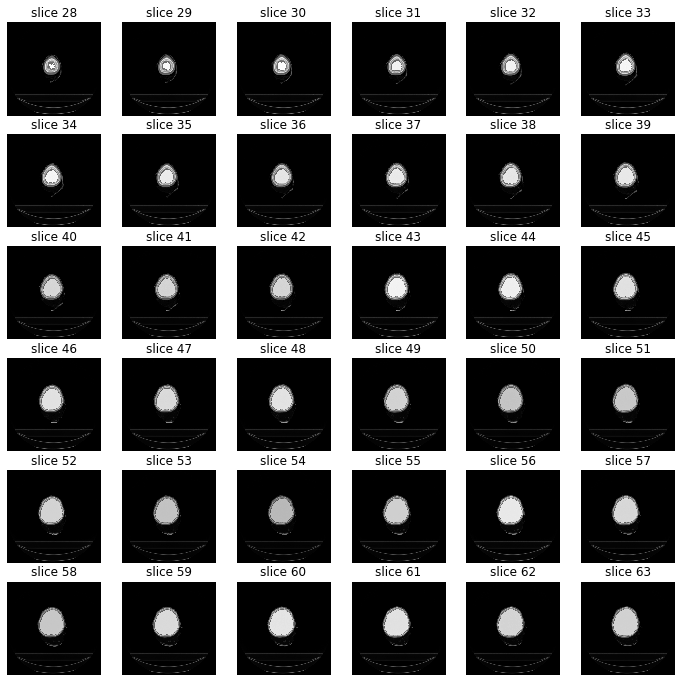

In [15]:
# visualize slices of pre op with contours
ind = 0
print(found[ind])
data.show_slices2D_contour(found[ind], show_every=1, start_with=index[ind])

# Segmentation

In [16]:
segmentor = Segmentation(data, debug=True)

In [17]:
segmentor.patient.contour_list_names_filtered['first'].values

array([28, 119, 121, 124, 122, 15, 72], dtype=object)

In [18]:
found = data.get_filtered_contour_names().values
index = data.contour_list_names_filtered['first'].values
found, index

(array(['Brain', 'PTV1', 'PTV2', 'GTV', 'CTV', 'Scalp', 'Corpus callosum'],
       dtype=object),
 array([28, 119, 121, 124, 122, 15, 72], dtype=object))

In [19]:
ind = 0
first = 72
contour = segmentor.active_contour(found[ind], postprocess = 0, 
                                   first=first, last=first+5, 
                                   kernel=(5,5), beta=0.1, w_edge=0.1, max_iterations=100,
                                   debug=True)
np.shape(contour)

INFO: Select data.
INFO: Start segmentation of Brain.
C:\Users\Caroline\Documents\KidsBrainProject\KidsBrainProject\utils\Segmentation.py:137: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.
  convergence=convergence, boundary_condition=boundary_condition)
INFO: ... slice: 72, time: 5.542830467224121
INFO: ... slice: 73, time: 0.9997098445892334
INFO: ... slice: 74, time: 1.0077154636383057
INFO: ... slice: 75, time: 0.8636152744293213
INFO: ... slice: 76, time: 0.8195812702178955


(5, 512, 512)

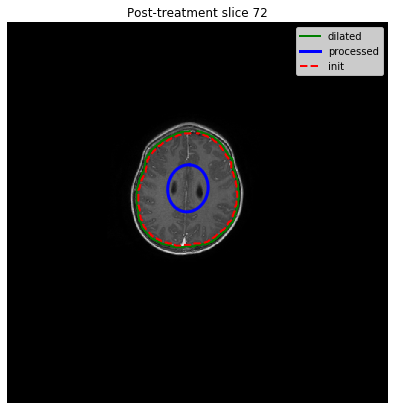

In [20]:
segmentor.show_segmentation_single(index=0)

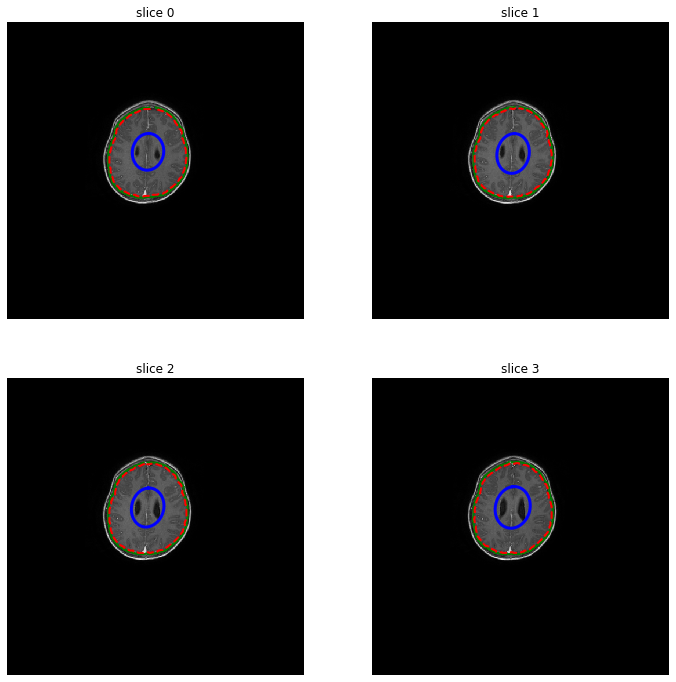

In [21]:
segmentor.show_segmentation_stack(2,2)

### Segmentation error metrics

(512, 512) (512, 512)


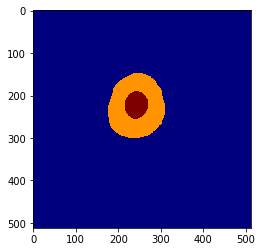

In [22]:
predicted = contour[0]
groundtruth = data.get_contour_overlay('Brain')[first] # Corpus callosum
plt.imshow(predicted+groundtruth*3, cmap = 'jet')
print(predicted.shape, groundtruth.shape)

#### Dice Coefficient

In [23]:
k = 255
dice = np.sum(predicted[groundtruth==k])*2.0 / (np.sum(predicted) + np.sum(groundtruth))
dice

0.2944564815304127

#### volumentric overlap error

In [24]:
k = 255
overlap = 1- np.sum(predicted[groundtruth==k])*2.0 / (np.sum(predicted+groundtruth))
overlap

0.7055435184695873

#### Hausdorff distance

In [25]:
import scipy
from scipy.spatial.distance import cdist

In [26]:
hausdorff = scipy.spatial.distance.directed_hausdorff(groundtruth,predicted,1)
hausdorff

(2266.4895764154753, 232, 223)

In [27]:
distance = cdist(groundtruth, predicted,'euclidean')
dist1 = np.max(np.min(distance,axis=0))
dist2 = np.max(np.min(distance,axis=1))
hausdorff = max(dist1, dist2)
hausdorff

2266.4895764154753

In [28]:
distance = cdist(groundtruth, predicted,'euclidean')
dist1 = np.mean(np.min(distance,axis=0))
dist2 = np.mean(np.min(distance,axis=1))
mod_hausdorff = max(dist1, dist2)
mod_hausdorff

533.4838505400323

In [29]:
dice, vol_error, hausdorff = segmentor.evaluate_segmentation()

INFO:Start evaluation ...
INFO:... Segmentation error metrics for slice 72 
    Dice coefficient: 0.2944564815304127 
    Volumetric overlap error: 0.7055435184695873 
    Mod hausdorff distance: 533.4838505400323
INFO:... Segmentation error metrics for slice 73 
    Dice coefficient: 0.32028433089523023 
    Volumetric overlap error: 0.6797156691047698 
    Mod hausdorff distance: 526.6635818565376
INFO:... Segmentation error metrics for slice 74 
    Dice coefficient: 0.31252558329922225 
    Volumetric overlap error: 0.6874744167007778 
    Mod hausdorff distance: 526.0155105776465
INFO:... Segmentation error metrics for slice 75 
    Dice coefficient: 0.34821029638087675 
    Volumetric overlap error: 0.6517897036191233 
    Mod hausdorff distance: 509.08106065687434
INFO:... Segmentation error metrics for slice 76 
    Dice coefficient: 0.33972711093533714 
    Volumetric overlap error: 0.6602728890646629 
    Mod hausdorff distance: 524.3488290360978


In [31]:
np.mean(dice)

0.32304076060821585